In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

from nanonets import Simulation
from nanonets.utils import autocorrelation
from scipy.linalg import eig

plt.style.use(["science","bright"])
%matplotlib inline

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Parameter
N_PARTICLES     = 9
V_RANGE         = 0.01
N_SAMPLES       = 100

# Topology
# topo = {"Nx": N_PARTICLES, "Ny": N_PARTICLES,
#         "e_pos" : [[0,0], [int((N_PARTICLES-1)/2),0], [N_PARTICLES-1,0],
#                     [0,int((N_PARTICLES-1)/2)], [0,N_PARTICLES-1],
#                     [N_PARTICLES-1,int((N_PARTICLES)/2)],
#                     [int((N_PARTICLES)/2),(N_PARTICLES-1)], [N_PARTICLES-1,N_PARTICLES-1]],
#         "electrode_type" : ['constant']*8}

topo = {"Nx": N_PARTICLES, "Ny": N_PARTICLES,
        "e_pos" : [[0,0], [N_PARTICLES-1,N_PARTICLES-1]],
        "electrode_type" : ['constant']*2}

# Voltages
N_ELECTRODES    = len(topo["electrode_type"])
volt            = np.zeros(shape=(N_SAMPLES,N_ELECTRODES+1))
volt[:,0]       = np.logspace(-4,3,N_SAMPLES)

# Simulation Class
sim_class = Simulation(topo)
sim_class.build_conductance_matrix()

# Capacitance and Conductance Matrix
cap_m   = sim_class.get_capacitance_matrix()*1e-18
g_m     = sim_class.get_conductance_matrix()[:-N_ELECTRODES,:-N_ELECTRODES]
e_v, _  = eig(g_m, cap_m)
e_real  = np.real(e_v)
e_valid = e_real[e_real > 1e-9]
lamda_m = np.min(e_valid)
tau_RC  = 1.0 / lamda_m
print(tau_RC)

1.0678984810796376e-08


In [14]:
# Run Simulation
sim_dic = {
        "error_th"        : 0.0,
        "max_jumps"       : 1,
        "eq_steps"        : 0,
        "jumps_per_batch" : 1,
        "kmc_counting"    : False,
        "min_batches"     : 5}
t_total = []
for v in volt:
    sim_class = Simulation(topo)
    sim_class.run_static_voltages(np.array([v.tolist()]), target_electrode=(N_ELECTRODES-1), sim_dic=sim_dic, verbose=True)
    t_total.append(1/np.sum(sim_class.model.tunnel_rates))

In [4]:
# Run Simulation
sim_dic = {
        "error_th"        : 0.0,
        "max_jumps"       : 50000,
        "eq_steps"        : 0,
        "jumps_per_batch" : 1,
        "kmc_counting"    : False,
        "min_batches"     : 5}
sim_class = Simulation(topo)
sim_class.run_static_voltages(volt, target_electrode=(N_ELECTRODES-1), sim_dic=sim_dic, verbose=True)

# Current Time Series
I_pB = sim_class.get_observable_per_batch()[:,:-1]*1e-6

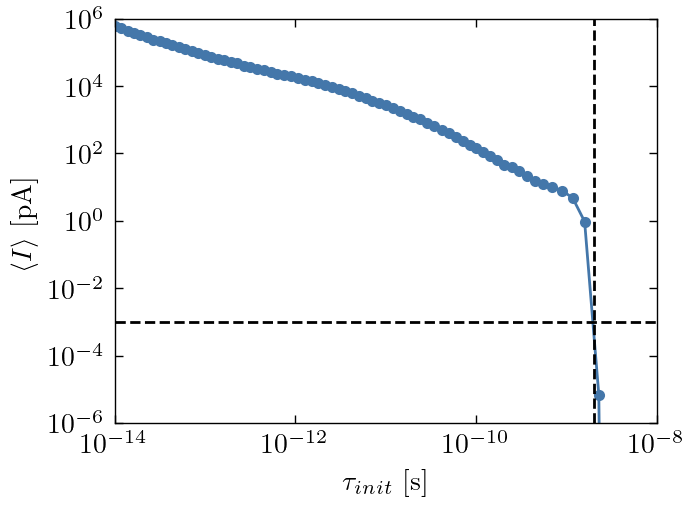

In [21]:
I_min   = 1e-3
fig, ax = plt.subplots(dpi=200)
_       = ax.plot(t_total, np.mean(I_pB[:,:],axis=1), marker='.')
_       = ax.set_xlabel('$\\tau_{init}$ [s]')
_       = ax.set_ylabel('$\\langle I \\rangle$ [pA]')
_       = ax.set_xlim(1e-14,1e-8)
_       = ax.set_ylim(1e-6,1e6)
_       = plt.axhline(I_min, color='black', ls='--')
_       = plt.axvline(2e-9, color='black', ls='--')
ax.set_xscale('log')
ax.set_yscale('log')

In [22]:
2e-9/tau_RC

0.1872837198886185

## Electric Current

In [ ]:
pot_pB      = sim_class.get_potential_per_batch()[:,:-1,:]*1000
acf         = np.array([autocorrelation(I_pB[n,:], I_pB[n,:], 500) for n in range(N_SAMPLES)])
acf_mean    = np.mean(acf,axis=0)
acf_std     = np.std(acf,axis=0)

(0.0, 1.0)

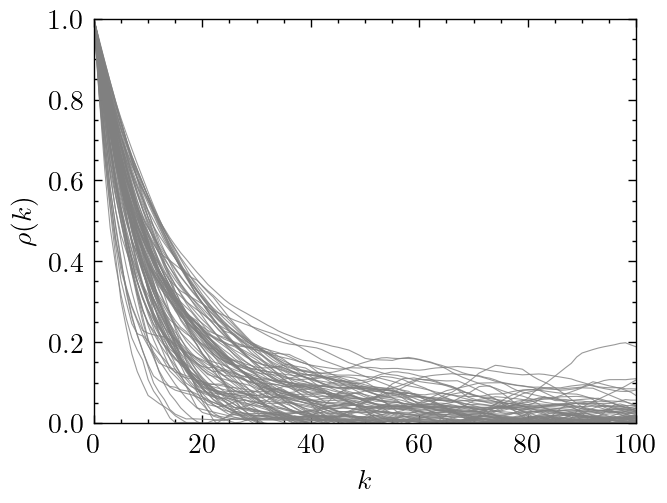

In [241]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for n in range(N_SAMPLES):
    ax.plot(acf[n,:], lw=0.4, color='grey', alpha=0.8)
ax.set_xlabel("$k$")
ax.set_ylabel("$\\rho(k)$")
ax.set_xlim(0,100)
ax.set_ylim(0,1)

(0.0, 1.0)

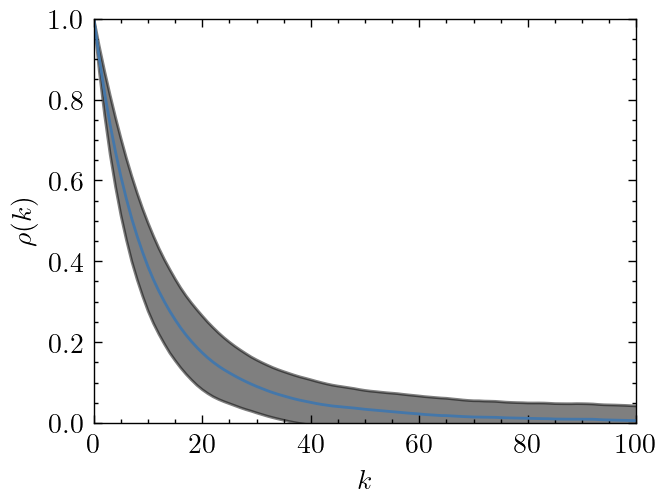

In [243]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(acf_mean)
ax.fill_between(np.arange(500), acf_mean-acf_std, acf_mean+acf_std, color='black', alpha=0.5)
ax.set_xlabel("$k$")
ax.set_ylabel("$\\rho(k)$")
ax.set_xlim(0,100)
ax.set_ylim(0,1)

Text(0, 0.5, '$I$ [nA]')

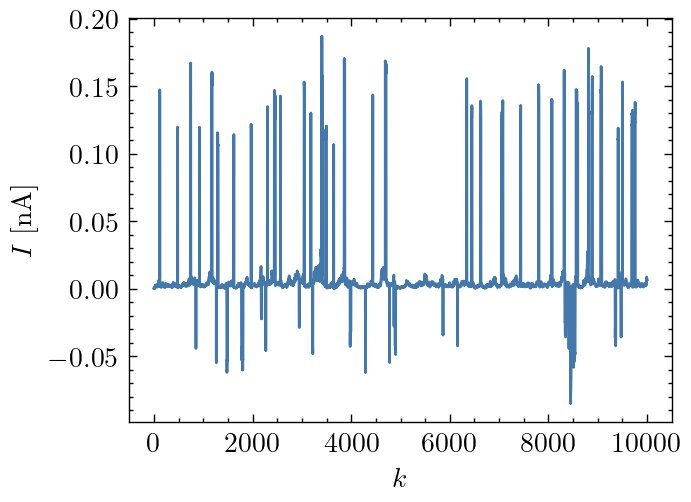

In [244]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(I_pB[2,:])
ax.set_xlabel("$k$")
ax.set_ylabel("$I$ [nA]")

## Potentials

In [167]:
acf_pot = []
for n in range(N_SAMPLES):
    acf_tmp = []
    for e in range(8,89):
        vals    = pot_pB[n,:-1,e]
        acf_val = autocorrelation(vals, vals, 100)
        acf_tmp.append(acf_val)
    acf_pot.append(acf_tmp)
acf_pot = np.array(acf_pot)

(0.0, 1.0)

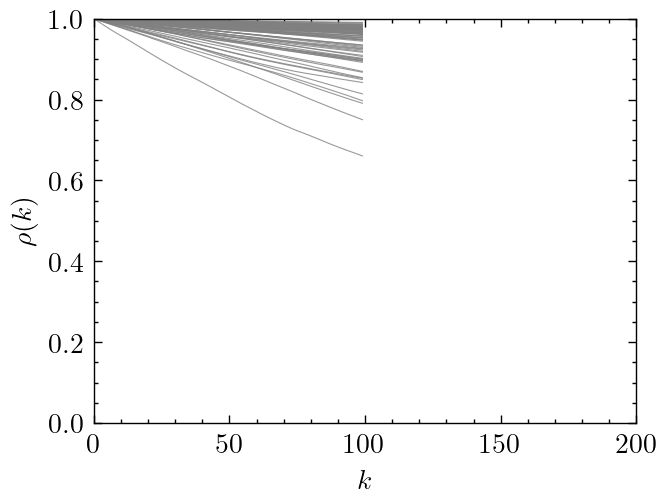

In [168]:
n = 30

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

for e in range(81):
    ax.plot(acf_pot[n,e,:], lw=0.4, color='grey', alpha=0.8)

ax.set_xlabel("$k$")
ax.set_ylabel("$\\rho(k)$")
ax.set_xlim(0,200)
ax.set_ylim(0,1)

Text(0, 0.5, '$\\phi$ [mV]')

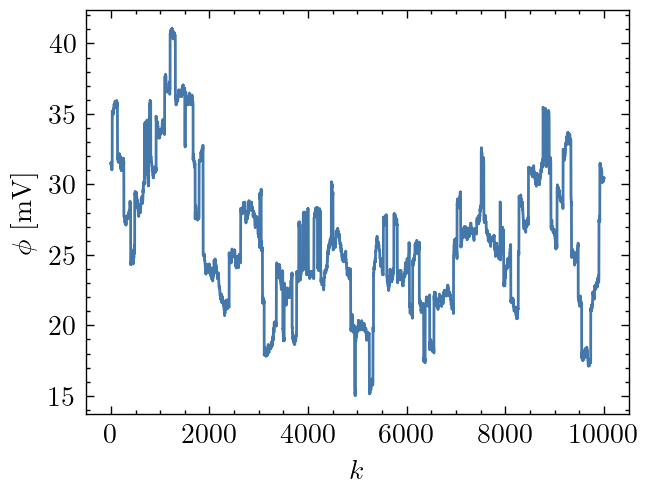

In [207]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(pot_pB[0,:-1,10])
ax.set_xlabel("$k$")
ax.set_ylabel("$\phi$ [mV]")

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

ax.plot(acf_pot[0,e,:], lw=0.4, color='grey', alpha=0.8)
ax.set_xlabel("$k$")
ax.set_ylabel("$\\rho(k)$")
ax.set_xlim(0,100)
ax.set_ylim(0,1)

In [7]:
def return_topology(N):
    topology_parameter = {
        "Nx"    : N,
        "Ny"    : N,
        "Nz"    : 1,
        "e_pos" :   [[0,0,0], [int((N-1)/2),0,0], [N-1,0,0],
                    [0,int((N-1)/2),0], [0,N-1,0], [N-1,int((N)/2),0],
                    [int((N)/2),(N-1),0], [N-1,N-1,0]]
    }
    return topology_parameter

def return_sim_info(jumps_per_batch=1000, min_batches=1, eq_steps=100000, max_jumps=10000000):
    sim_dic = {
        'error_th'          : 0.05,
        'max_jumps'         : max_jumps,
        'eq_steps'          : eq_steps,
        'jumps_per_batch'   : jumps_per_batch,
        'kmc_counting'      : False,
        'min_batches'       : min_batches
    }
    return sim_dic

def return_voltages(V_min, V_max, N_voltages=100, seed=0):

    rs = np.random.RandomState(seed)

    return rs.uniform(V_min, V_max, size=(N_voltages,9))

In [8]:
N           = 7
voltages    = return_voltages(-0.05, 0.05)
topology    = return_topology(N)

results     = {}

for jumps_per_batch in [1,10,100,1000,10000]:

    sim_dic     = return_sim_info(jumps_per_batch=jumps_per_batch)
    sim_class   = nanonets.simulation(network_topology='cubic', topology_parameter=topology)
    sim_class.run_const_voltages(voltages=voltages, target_electrode=7, sim_dic=sim_dic, save_th=0.1)

    results[jumps_per_batch] = sim_class.return_output_values()

In [28]:
df      = pd.DataFrame()

for jumps_per_batch in [1,10,100,1000,10000]:

    df[jumps_per_batch] = results[jumps_per_batch][:,2]

,1,10,100,1000,10000
0,-177.896736,-139.853343,-135.476525,-138.213046,-138.333461
1,58.530523,58.950328,56.783800,57.257364,58.152432
2,-40.522137,-49.244563,-48.612042,-39.661505,-47.487662
3,260.458233,235.655722,223.589801,252.759934,233.018930
4,290.369193,249.237828,257.150652,293.458882,269.248541
...,...,...,...,...,...
95,147.041726,240.587297,224.337637,234.463636,226.303486
96,729.561819,254.191806,269.288444,245.677997,237.482177
97,-0.314858,-0.267156,-0.268071,-0.248300,-0.287208
98,-806.358033,-182.202846,-222.059459,-216.312312,-198.376550


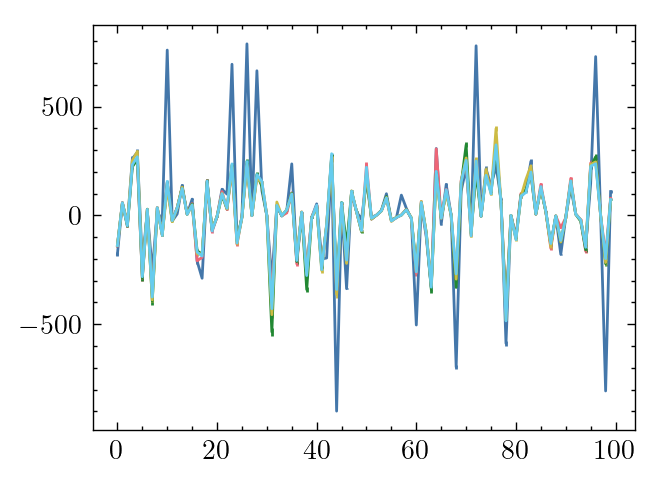

In [18]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for jumps_per_batch in [1,10,100,1000,10000]:

        ax.errorbar(np.arange(100), results[jumps_per_batch][:,2], results[jumps_per_batch][:,3])
    
    ax.set_ylabel("$I$ [pA]")
    ax.set_xlabel("data")

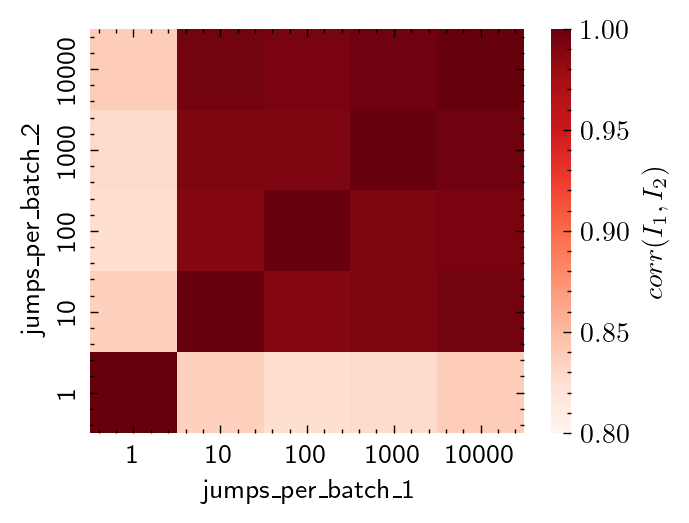

In [40]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.heatmap(df.corr(), ax=ax, cmap='Reds', cbar_kws={'label':'$corr(I_1,I_2)$'}, vmin=0.8)
    
    ax.set_xlabel('jumps_per_batch_1')
    ax.set_ylabel('jumps_per_batch_2')
    ax.invert_yaxis()

<ErrorbarContainer object of 3 artists>

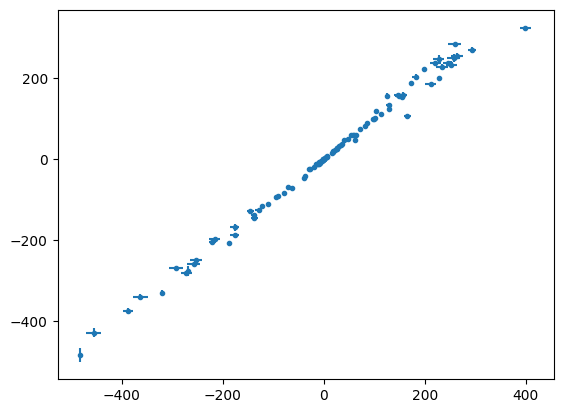

In [26]:
jumps_per_batch1    = 1000
jumps_per_batch2    = 10000

plt.errorbar(results[jumps_per_batch1][:,2], results[jumps_per_batch2][:,2], results[jumps_per_batch2][:,3], results[jumps_per_batch1][:,3], fmt='.')

In [36]:
N           = 7
voltages    = return_voltages(-0.05, 0.05)
topology    = return_topology(N)

results2     = {}

for min_batches in [1,2,4,6,8,10]:

    sim_dic     = return_sim_info(min_batches=min_batches)
    sim_class   = nanonets.simulation(network_topology='cubic', topology_parameter=topology)
    sim_class.run_const_voltages(voltages=voltages, target_electrode=7, sim_dic=sim_dic, save_th=0.1)

    results2[min_batches] = sim_class.return_output_values()

In [38]:
df2      = pd.DataFrame()

for min_batches in [1,2,4,6,8,10]:

    df2[min_batches] = results2[min_batches][:,2]

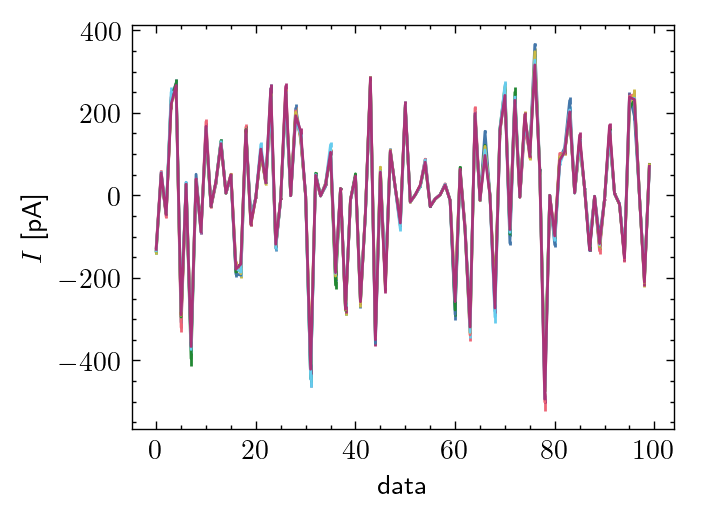

In [37]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for min_batches in [1,2,4,6,8,10]:

        ax.errorbar(np.arange(100), results2[min_batches][:,2], results2[min_batches][:,3])
    
    ax.set_ylabel("$I$ [pA]")
    ax.set_xlabel("data")

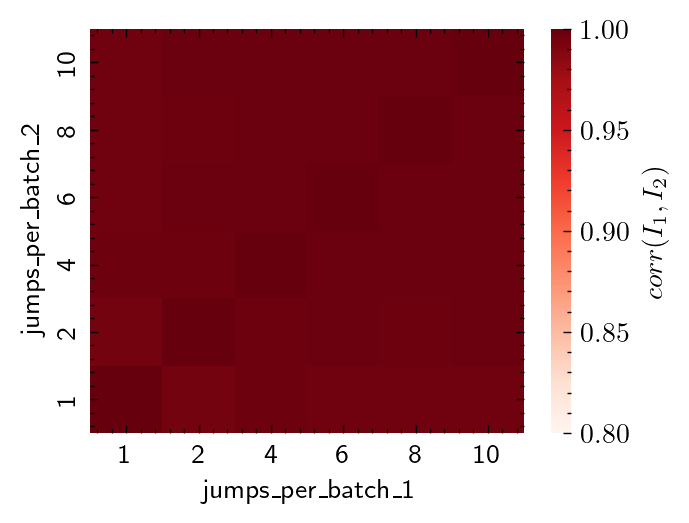

In [41]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.heatmap(df2.corr(), ax=ax, cmap='Reds', cbar_kws={'label':'$corr(I_1,I_2)$'}, vmin=0.8)
    
    ax.set_xlabel('jumps_per_batch_1')
    ax.set_ylabel('jumps_per_batch_2')
    ax.invert_yaxis()